In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate, UnitaryGate
import qiskit.quantum_info as qi
import galois

## Deutsch's Algorithm

The premise of Deutsch's Algorithm is simple. Suppose we have a function
$$f: \Sigma \to \Sigma$$
where $\Sigma = \{0, 1\}$. Suppose we also know that this function is either constant, in which case it maps every input to the exact same number, or it is balanced, in which case the two inputs are mapped to different numbers. Given an arbitrary function of this form, how can we determine which type of function this is?

Classically, this would require us to to make two separate queries, f(0) and f(1), in order to determine the type of function. However, using quantum computing, we can determine the type of function using only one function evaluation via Deutsch's algorithm.

### Description of Algorithm

We start by initializing the state $|01\rangle$, where $x = 0$ and $y = 1$ (in the qiskit circuit, we will need to NOT $y$ to obtain 1 since all registers initialized to 0). In order to perform quantum parallelism, we must perform a Hadamard operation on $x$ to produce an equal superposition of 0 and 1. Furthermore, we can perform a Hadamard on $y$, giving us that state

$$|\psi_1\rangle = (H \otimes H)|xy\rangle = (\frac{|0\rangle + |1\rangle}{\sqrt2})(\frac{|0\rangle - |1\rangle}{\sqrt2})$$

We can then evaluate a unitary gate which maps $U_f: |x,y\rangle \mapsto |x,y\oplus f(x)\rangle$. To do this, we first observe that

$$U_f|x-\rangle = (-1)^{f(x)}|x-\rangle$$

since if the function maps to 1, then $|- \oplus f(x)\rangle = -|-\rangle$, as the 0 and 1 states are swapped. Therefore, we have the two following expressions if $f(0) = f(1)$ or $f(0) \ne f(1)$ after $U_f$ is evaluated:

$$|\psi_2\rangle = \begin{cases}
\pm |+-\rangle, & f(0) = f(1) \\
\pm |--\rangle, & f(0) \ne f(1)
\end{cases}$$

Hence, we can see that $x$ will now be in either state $|+\rangle$ if the function is constant or $|-\rangle$ if the function is balanced. Since these states are orthogonal, we can distinguish between these states with 100% certainty by measuring in the basis $|+\rangle, |-\rangle$. To do this, we simply apply a Hadamard operation to $x$, giving us

$$|\psi_3\rangle = \begin{cases}
\pm |0-\rangle, & f(0) = f(1) \\
\pm |1-\rangle, & f(0) \ne f(1)
\end{cases}$$

This means that if we measure $x$ and get 0, the function must be constant, and if we get 1, the function must be balanced. Therefore, with only a single evaluation of the function, we can calculate $f(0) \oplus f(1)$, telling us whether the function is constant or balanced

### Implementation

In [21]:
def deutsch_function(case: int):
    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

def compile_circuit(function: QuantumCircuit):
    X = QuantumRegister(1, "X")
    Y = QuantumRegister(1, "Y")
    z = ClassicalRegister(1, "z")

    circuit = QuantumCircuit(X, Y, z)
    circuit.x(Y)
    circuit.h(X)
    circuit.h(Y)

    circuit.barrier()
    circuit.compose(function, inplace=True)
    circuit.barrier()
    
    circuit.h(X)
    circuit.measure(X, z)
    display(circuit.draw('mpl'))
    return circuit

The cases in the deutsch_function function correspond to the following functions:

1. $f(0) = 0$, $f(1) = 0$

2. $f(0) = 0$, $f(1) = 1$

3. $f(0) = 1$, $f(1) = 0$

4. $f(0) = 1$, $f(1) = 1$

Consequently, we can see that 1 and 4 are constant, and 2 and 3 are balanced

In [22]:
def deutsch_algorithm(case: int):
    """
    Determine if a Deutsch function is constant or balanced.
    """
    qc = compile_circuit(deutsch_function(case))

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if measurements[0] == "0":
        return "constant"
    return "balanced"

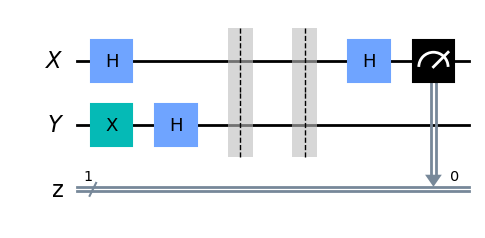

'constant'

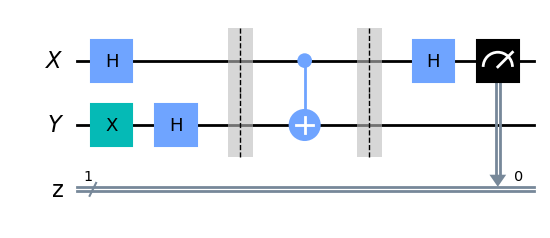

'balanced'

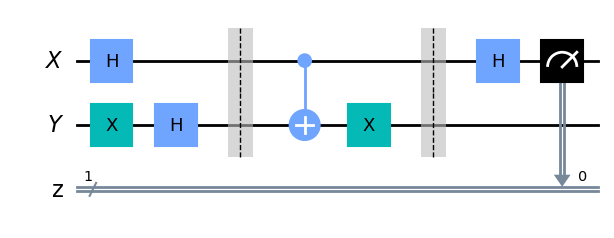

'balanced'

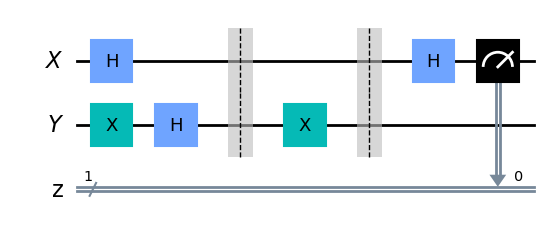

'constant'

In [28]:
for i in range(1, 5):
    display(deutsch_algorithm(i))

## Deutsch-Josza Algorithm

The Deutsch-Josza Algorithm is a generalization of Deutsch's Algorithm which involves a function
$$f: \Sigma^n \to \Sigma$$
where $\Sigma = \{0, 1\}$. In this context, we define a constant function as one in which every possible n-qubit string maps to the same digit and a balanced function as one in which half of the inputs map to 0 and the other half to 1.

Classically, we would solve this problem by evaluating the function for different inputs until we either get an output which is different from the rest, in which case the function is balanced. If we evaluate one more than half of the inputs and they all have the same output, we know that the function is constant. Therefore, in the worst case, for a given $n$-bit input, we would need to perform $2^{n-1} + 1$ queries to solve this problem, meaning that the time complexity is now exponential.

However, quantum computing provides a significant speedup, solving this problem in a single query!

### Description of the Algorithm

We start by initializing the state $|0^{\oplus n}1\rangle$, where $x = 0^{\oplus n}$ and $y = 1$ (in the qiskit circuit, we will need to NOT $y$ to obtain 1 since all registers initialized to 0). In order to perform quantum parallelism, we must perform Hadamard operations on each qubit of the $x$ register to produce an equal superposition of every $n$-qubit state. Furthermore, we can perform a Hadamard on $y$, giving us that state

$$|\psi_1\rangle = H^{\otimes {n + 1}}|xy\rangle = (\frac{1}{\sqrt{2^n}}\sum_{x \in \{0, 1\}^n} |x\rangle)(\frac{|0\rangle - |1\rangle}{\sqrt2})$$

We can then evaluate a unitary gate which maps $U_f: |x,y\rangle \mapsto |x,y\oplus f(x)\rangle$. To do this, we again observe that

$$U_f|x-\rangle = (-1)^{f(x)}|x-\rangle$$

since if the function maps to 1, then $|- \oplus f(x)\rangle = -|-\rangle$, as the 0 and 1 states are swapped. Therefore, we have that

$$|\psi_2\rangle = (\sum_{x \in \{0, 1\}^n} \frac{(-1)^{f(x)}}{\sqrt{2^n}}|x\rangle)(\frac{|0\rangle - |1\rangle}{\sqrt2})$$

We now need to apply a Hadamard operation to the $n$ qubits of $x$ in order to be able to parse this result, just as before. To understand the effect of this operation, we first observe that for a single qubit,

$$H|x\rangle = \sum_z (-1)^{xz}/\sqrt{2}|z\rangle$$

Generalizing this for $n$ bits, we have that

$$H^{\otimes n}|x\rangle = \sum_z \frac{(-1)^{x_1z_1 + x_2z_2 + ... + x_nz_n}}{\sqrt{2^n}}|z\rangle$$

$$= \sum_z \frac{(-1)^{x \cdot z}}{\sqrt{2^n}}|z\rangle$$

Therefore, we now have that

$$|\psi_3\rangle = (\sum_{x} \frac{(-1)^{f(x)}}{\sqrt{2^n}} \sum_z \frac{(-1)^{x \cdot z}}{\sqrt{2^n}}|z\rangle)(\frac{|0\rangle - |1\rangle}{\sqrt2})$$

$$= (\sum_{x}  \sum_z \frac{(-1)^{x \cdot z + f(x)}}{2^n}|z\rangle)(\frac{|0\rangle - |1\rangle}{\sqrt2})$$

We now observe that for $z = |0^{\otimes n}\rangle$, the coefficient is given by $\sum_x \frac{(-1)^{f(x)}}{2^n}$. Therefore, if the function is constant, this amplitude will either be 1 or -1 exactly, meaning that the other probability amplitudes must be zero. Otherwise, we can observe that half the values for $f(x) = 0$ and the other half have that $f(x) = 1$, meaning that these terms in the sum will destructively interfere, resulting in an amplitude of 0.

Therefore, we have that if we measure 0, the function must be constant, otherwise any other result indicates that the function is balanced.

In [14]:
def deutsch_josza_function(num_qubits: int):
    qc = QuantumCircuit(num_qubits + 1)
    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # next, choose half the possible input states
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

def compile_dj_circuit(function: QuantumCircuit, bits: int):
    X = QuantumRegister(bits, "X")
    Y = QuantumRegister(1, "Y")
    z = ClassicalRegister(bits, "z")

    circuit = QuantumCircuit(X, Y, z)
    circuit.x(Y)
    circuit.h(X)
    circuit.h(Y)

    circuit.barrier()
    circuit.compose(function, inplace=True)
    circuit.barrier()
    
    circuit.h(X)
    circuit.measure(X, z)
    display(circuit.draw('mpl'))
    return circuit

In [51]:
def deutsch_josza_algorithm(num_qubits: int):
    """
    Determine if a Deutsch function is constant or balanced.
    """
    qc = compile_dj_circuit(deutsch_josza_function(num_qubits), num_qubits)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if measurements[0] == ("0" * num_qubits):
        return "constant"
    return "balanced"

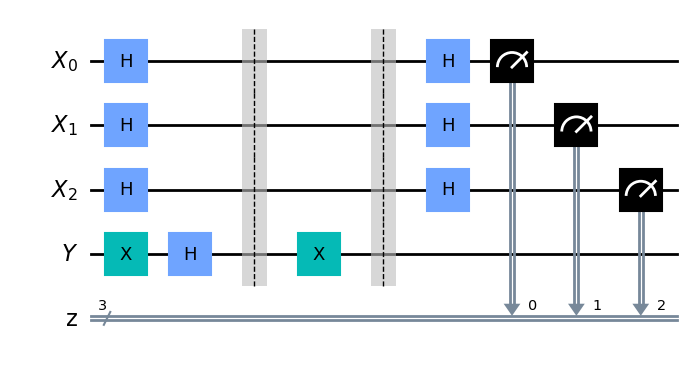

constant


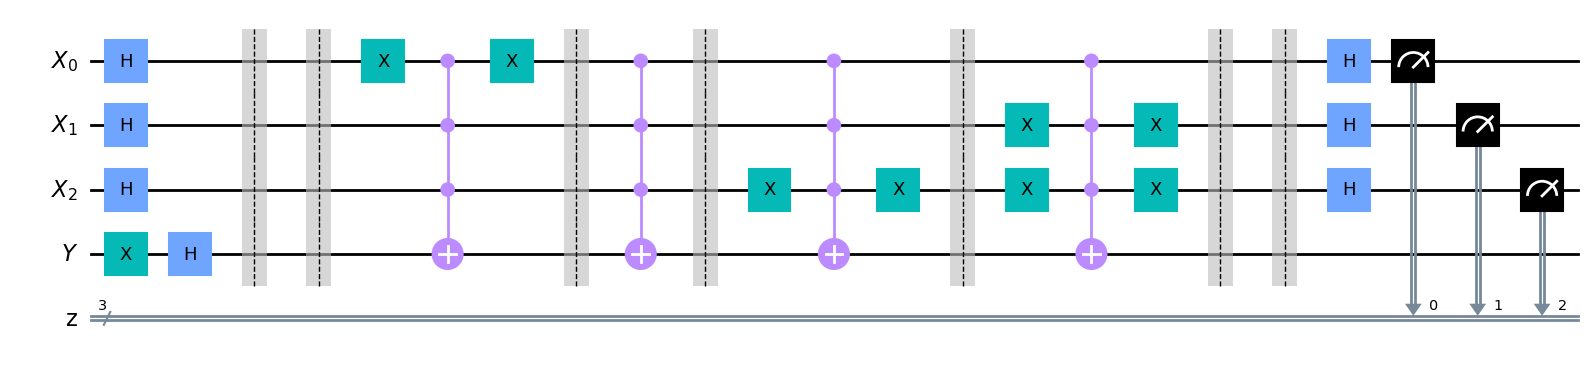

balanced


In [53]:
np.random.seed(10)
print(deutsch_josza_algorithm(3))
np.random.seed(1010)
print(deutsch_josza_algorithm(3))

To understand how the Deutsch-Josza function is encoded, we can observe that for those qubits that are part of the multicontrolled NOT gates, if the control check is straddled by NOT gates, then the qubit must be 0 to flip $y$, else it must be 1, allowing us to effectively encode the values of $x$ such that $f(x) = 1$, where it is implicitly assumed that for all other $x$, $f(x) = 0$.

## Bernstein-Vazirani Problem

Suppose we define
$$f: \Sigma^n \to \Sigma$$
such that $f(x) = x \cdot s$, for some $s \in \Sigma^n$, where $\cdot$ denotes the bitwise inner product modulo 2. The BV Problem asks us to find this string.

Solving this problem classically would require $n$ queries with strings of all zeros except for a single one in order to trace the string used in the product. However, in the quantum case, this problem can be solved in a single query.

### Description of the Algorithm

Starting at the point

$$|\psi_3\rangle = (\sum_{x}  \sum_z \frac{(-1)^{x \cdot z + f(x)}}{2^n}|z\rangle)(\frac{|0\rangle - |1\rangle}{\sqrt2})$$

we have that $f(x) = x \cdot s$. This gives us

$$|\psi_3\rangle = (\sum_{x}  \sum_z \frac{(-1)^{x \cdot z + x \cdot s}}{2^n}|z\rangle)(\frac{|0\rangle - |1\rangle}{\sqrt2})$$

$$= (\sum_{x}  \sum_z \frac{(-1)^{x \cdot (z \oplus s)}}{2^n}|z\rangle)(\frac{|0\rangle - |1\rangle}{\sqrt2})$$

We can now use the fact that

$$\frac{1}{2^n}\sum_x (-1)^{xz} = \begin{cases}
    1, & z = 0^{\otimes n} \\
    0, & \text{otherwise}
\end{cases}$$

This means that the only nonzero term in the sum will be when $z \oplus s = 0^{\otimes n}$, or in other words, when $z = s$. Therefore,

$$|\psi_3\rangle = |s-\rangle$$

Measuring the first $n$ bits now gives us the exact string used to perform the bitwise inner product modulo 2 with 100% certainty. 

In [54]:
def bernstein_vazirani_function(s: str):
    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

    qc.barrier()

    return qc

In [56]:
def bernstein_vazirani_algorithm(s: str):
    """
    Determine special string s from function mappings
    """
    qc = compile_dj_circuit(bernstein_vazirani_function(s), len(s))

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    return measurements[0]

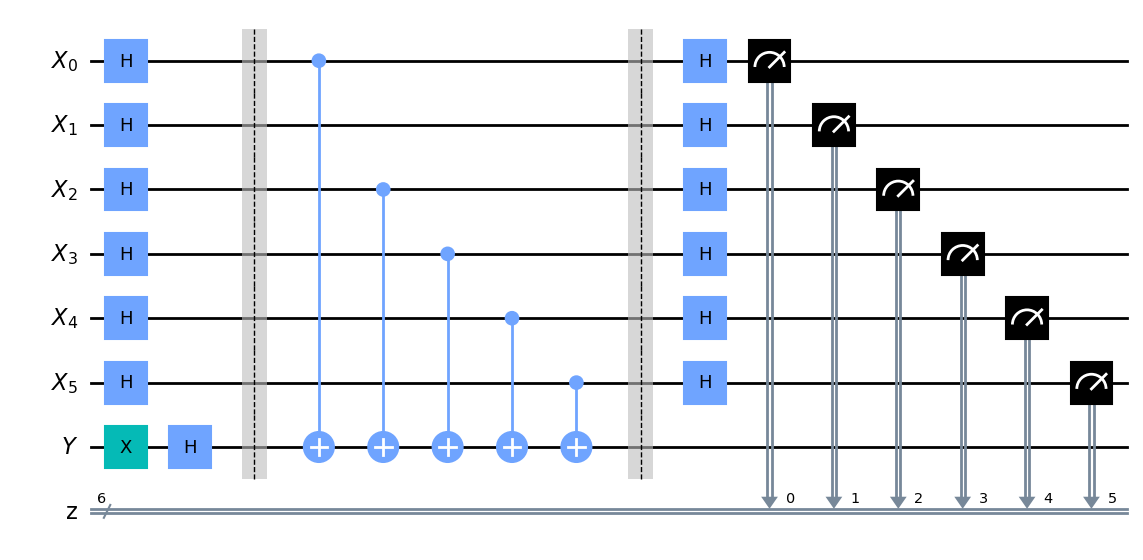

'111101'

In [60]:
bernstein_vazirani_algorithm('111101')

## Simon's Algorithm

Suppose we are given a function
$$f: \Sigma^n \to \Sigma^m$$
where we are promised that there exists a string $s \in \Sigma^n$ such that $f(x) = f(y) \Leftrightarrow x = y \lor x \oplus s = y$. What is the string $s$?

Classically, if we query this function less than $2^{n/2-1} - 1$ times, we will have a probability of at least 1/2 of failing to guess $s$, meaning that we need to make an expontential number of queries to solve this problem with reasonably high rpobability. With Simon's Algorithm; however, we can solve this problem with high certainty using only $O(n)$ queries as we will see below.

### Description of the Algorithm

We start with the state $|0^{\otimes m + n} \rangle$. We apply Hadamard transforms to the top $n$ qubits, giving us the state

$$|\psi_1 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \Sigma^n} |0^{\otimes m}\rangle|x\rangle$$

We then apply the unitary function $U_f$ which outputs $|f(x) \oplus y \rangle$ into the other $m$ qubits, giving

$$|\psi_2 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \Sigma^n} |f(x)\rangle|x\rangle$$

Performing the second set of Hadamard operations to the top $n$ bits gives

$$|\psi_3 \rangle = \frac{1}{2^n} \sum_{x \in \Sigma^n} \sum_{y \in \Sigma^n} (-1)^{x \cdot y} |f(x)\rangle|y\rangle$$

Looking at the probability of getting any given $y$, we have that

$$p(y) = \left\lVert \frac{1}{2^n} \sum_{x \in \Sigma^n} (-1)^{x \cdot y} |f(x)\rangle \right\rVert^2$$

$$p(y) = \left\lVert \frac{1}{2^n} \sum_{z \in \operatorname{range}(f)} \left( \sum_{x \in f^{-1}(\{z\})} (-1)^{x \cdot y} \right) |z\rangle \right\rVert^2$$

$$p(y) = \frac{1}{2^{2n}} \sum_{z \in \operatorname{range}(f)} \left\lvert \sum_{x \in f^{-1}(\{z\})} (-1)^{x \cdot y} \right\rvert^2$$

If $s = 0^{\otimes n}$, then the function will be injective, and there will only be one $x$ in the preimage of every $z$, meaning that the absolute value term evalues to just 1, giving $p(y) = \frac{1}{2^n}$.

If $s \ne 0^{\otimes n}$, then by the promise of Simon's problem, there must be two strings in the preimage of $z$ given by $w$ and $w \oplus s$, giving us that

$$\left\lvert \sum_{x \in f^{-1}(\{z\})} (-1)^{x \cdot y} \right\rvert^2 = \left\lvert (-1)^{y \cdot w} + (-1)^{y \cdot (w \oplus s)} \right\rvert^2$$

$$= \left\lvert (-1)^{y \cdot w}(1 + (-1)^{y \cdot s}) \right\rvert^2$$

$$= \left\lvert (1 + (-1)^{y \cdot s}) \right\rvert^2$$

$$= \begin{cases}
    4 & y \cdot s = 0 \\
    0 & y \cdot s = 1
\end{cases}$$

Therefore, since $|\operatorname{range}(f)| = 2^{n - 1}$, we have that

$$p(y) = \frac{1}{2^{2n}} \sum_{z \in \operatorname{range}(f)} \left\lvert \sum_{x \in f^{-1}(\{z\})} (-1)^{x \cdot y} \right\rvert^2$$

$$= \begin{cases}
    \frac{1}{2^{n - 1}} & y \cdot s = 0 \\
    0 & y \cdot s = 1
\end{cases}$$

Consequently, we can see that we will only measure those strings whose bitwise inner product mod 2 results in 0. By running the circuit several times, we can accumulate a set of strings output by the function given by $y^1, y^2, ..., y^k$. We then write out all their bits in a matrix form, giving us

$$M = \begin{pmatrix}
    y^1_{n - 1} & \dots & y^1_0 \\
    \vdots & \ddots & \cdots \\
    y^k_{n - 1} & \dots & y^k_0
\end{pmatrix}$$

We can imagine that if we wrote out the string $s$ as a vector $v$ and multiplied $Mv$ mod 2, then the result will be zero. Consequently, $v \in \operatorname{ker}(M)$.

Performing this process $n + r$ times gives us a probability of $1 - 2^{-r}$ of failure, meaning that if $r$ is decently large, we have a very large chance of success. Hence, we have to use a linear number of inputs to compute the string with high probability.

The following code is taken directly from the Qiskit course:

In [2]:
def simon_function(s: str):
    """
    Create a QuantumCircuit implementing a query gate for Simon problem obeying the promise for the hidden string `s`
    """
    # Our quantum circuit has 2n qubits for n = len(s)
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutation will effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function g(x) = min{x,x ^ s}, which
    # is a simple function that satisfies the promise, and then we take f to be the composition of g and the random
    # permutation pi. This gives us a random function satisfying the promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

In [3]:
def simon_measurements(problem: QuantumCircuit, k: int):
    n = problem.num_qubits // 2
    
    qc = QuantumCircuit(2 * n, n)
    
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    
    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()

In [4]:
def simon_algorithm(problem : QuantumCircuit):
    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10)
    print("Measurement results:")
    display(measurements)
    
    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()
    print("Null space:")
    display(null_space)

    # 3. Convert back to a string
    print("Guess for hidden string s:")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

In [5]:
display(simon_algorithm(simon_function("101101")))

Measurement results:


['000111',
 '011100',
 '100100',
 '100100',
 '010101',
 '010010',
 '010111',
 '110110',
 '001100',
 '110100',
 '000010',
 '010111',
 '100011',
 '110110',
 '100001',
 '110110']

Null space:


GF([[1, 0, 1, 1, 0, 1]], order=2)

Guess for hidden string s:


'101101'